# Feature selection ;)

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [2]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(test_X, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(train_y, test_y, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, pred, times)

    print(f"Concordance Uno: {round(uno_concordance[0], 3)}")
    print(f"IBS: {round(ibs, 3)}")
    print(f"Mean AUC: {round(mean_auc,3)}")

    return uno_concordance, ibs, mean_auc

In [3]:
# pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'
pickle_file = 'data/COX_DATA_FULL_LIVING_EXPERIMENTAL.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [4]:
dataset.shape

(53082, 58)

In [5]:
yes_categorical=["PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ABO_MAT", 
                "ETHCAT", 
                "ETHCAT_DON",
                'HBV_CORE', 
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
                
                # 'HBV_SUR_ANTIGEN', # negative importance
                # "ABO", # negative importance
                # "ABO_DON", # negative importance
                # 'HBV_SUR_ANTIGEN_DON',  # negative importance
                # "GENDER_DON", # negative importance
                # "DIABETES_DON", # zero importance
                
            ]
yes_numerical = [   
                "KI_CREAT_PREOP",
                # "SERUM_CREAT", # really?? vice versa
                "NPKID", 
                "AGE", 
                "HGT_CM_CALC", 
                "BMI_DON_CALC",
                "AGE_DON",
                "DIALYSIS_TIME",
                # "KDPI",

                # HLA with some importance
                # 'DR1', 
                # 'BW6', 
                # 'BW4', 
                # 'RA1',
                # 'A2', 
                # 'DR53', 
                # 'C1', 
                # 'C2', 
                # 'A1',
                # 'RA2', 
                # 'DR51',
                # 'DR52', 
                # 'DQ2', 
                # 'RDR1',
                
                # 'BMIS', # negative importance
                # 'AMIS', # negative importance    
                # 'DR52_2', # zero importance
                # 'DR53_2', # zero importance
                # 'B2', # negative importance
                # "CREAT_TRR", # negative importance
                # 'DR2', # negative importance
                # 'RB1',# negative importance
                # 'B1', # negative importance
                # "BMI_CALC", # negative importance 
                # "WGT_KG_CALC", # negative importance
                # "WGT_KG_DON_CALC", # negative importance
                # "HGT_CM_DON_CALC", # negative importance
                # 'DQ1',# negative importance
                # 'RB2',# negative importance
                # 'RDR2',# negative importance
                ]

In [6]:
dataset[yes_numerical].quantile([0.01, 0.99])

,DIALYSIS_TIME
0.01,0.00
0.99,3100.76


In [7]:
dataset[yes_numerical] = dataset[yes_numerical].astype(float)

dataset[yes_numerical].dtypes

KI_CREAT_PREOP    float64
NPKID             float64
AGE               float64
HGT_CM_CALC       float64
BMI_DON_CALC      float64
AGE_DON           float64
DIALYSIS_TIME     float64
dtype: object

In [8]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

def preprocess_data(feature_importance):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, yes_numerical),
                ('cat', categorical_transformer, yes_categorical)
            ]
        )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

    if feature_importance:
        categorical_x = encode_categorical(dataset[yes_categorical])
        numerical_x = standardize(dataset[yes_numerical])
        X = pd.concat([numerical_x, categorical_x], axis=1)
    else:
        X = pipeline.fit_transform(dataset[yes_categorical + yes_numerical])
    
    survival_time = dataset["PTIME"].astype(np.float64)
    event = dataset["PSTATUS"].astype(float).astype(bool)
    y = Surv.from_arrays(event, survival_time, "Status", "Days")

    return X, y


X, y = preprocess_data(True)

In [9]:
# save the preprocessor
# with open('pickle/pipeline_coxnet_living.pkl', 'wb') as f:
    # pickle.dump(pipeline, f)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [11]:
from tqdm._tqdm_notebook import tqdm
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_

cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=-1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

/var/folders/c7/7_0s689j2m99wkwqx2b0skvm0000gn/T/ipykernel_21579/1667922982.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm
/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)


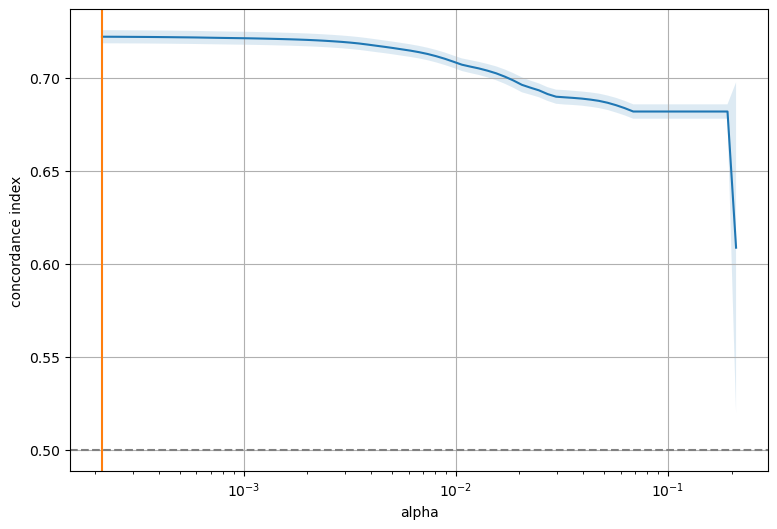

In [12]:
import matplotlib.pyplot as plt

alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [13]:
print("Best alpha:", gcv.best_params_["alphas"][0])

Best alpha: 0.00021510636871239242


In [14]:
best_params = gcv.best_params_

coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[best_params['alphas'][0]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)
_,_,_ = evaluate_model(coxnet_pred, X_test, y_test, y_train, times)

Concordance Uno: 0.722
IBS: 0.136
Mean AUC: 0.741


Concordance Uno: 0.723
IBS: 0.136
Mean AUC: 0.743

Number of non-zero coefficients: 34


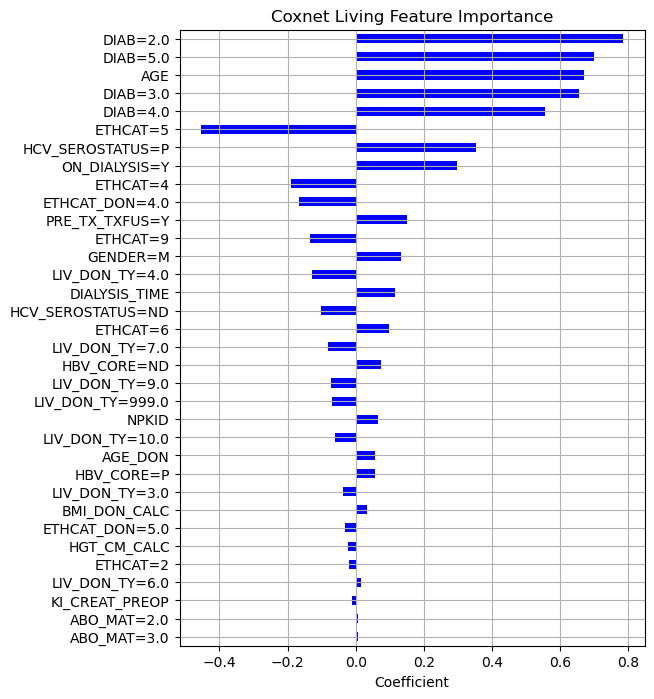

In [15]:
from sklearn.inspection import permutation_importance

best_model = gcv.best_estimator_
best_coefs = pd.DataFrame(best_model.coef_, index=X.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False, color='blue')
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False, color='blue')
ax.set_xlabel("Coefficient")
ax.set_title("Coxnet Living Feature Importance")
ax.grid(True)
plt.show()

In [16]:
import pickle

# pickle_file = 'pickle/COXNET_LIVING_MODEL_FINAL.pickle'

# with open(pickle_file, 'wb') as f:
#     pickle.dump(coxnet_pred, f)


In [17]:
# keep it commented in order to avoid putting wrong model into the application
# run it only if you are sure that the model and the pipeline are good

# ! bash export_models.sh

In [18]:
X_train.shape

(42465, 45)

# Pickle model evaluation for later plotting in `result_plot.ipynb`

In [19]:
from sksurv.metrics import brier_score

# surv_fn = coxnet_pred.predict_survival_function(X_test, return_array=False)

# surv_prob = np.row_stack([fn(times) for fn in surv_fn])

# bs = brier_score(y_train, y_test, surv_prob, times)
# ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#times)
# print('Integrated Brier Score:', ibs)

In [20]:
import matplotlib.pyplot as plt


# plt.figure(figsize=(10,6))
# plt.plot(bs[0], bs[1], marker=",")
# # plt.axhline(ibs, linestyle="--")
# # plt.text(5, 0, "{model}", fontsize=12)
# plt.title("Time-dependent Brier Score for the Random Survival Forest")
# plt.xlabel("days")
# plt.ylabel("time-dependent Brier Score")

In [21]:
import pickle
# pickle  the Brier Score of the final model
# with open('pickle/brier/BS_COXNET_LIVING_FINAL.pickle', 'wb') as f:
#     pickle.dump(bs, f)


In [22]:
# estimation of AUC of final model
# lower, upper = np.percentile(y_train["Days"], [10, 90])
# times = np.arange(lower, upper + 1)
# cph_risk_scores = coxnet_pred.predict(X_test)
# auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)

# with open('pickle/AUC/AUC_COXNET_LIVING_FINAL.pickle', 'wb') as f:
#     pickle.dump((times, auc, mean_auc), f)

# Feature Importance

In [52]:
from sklearn.inspection import permutation_importance

# uncoment if you want to calculate permutation importance (data must not be processed by pipeline)
result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

In [89]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features
columns = yes_numerical + yes_categorical

def format_number(x):
    return '{:.10f}'.format(x)

importances_df = pd.DataFrame(result.importances_mean, index=X_test.columns)
importances_df = importances_df.applymap(format_number)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

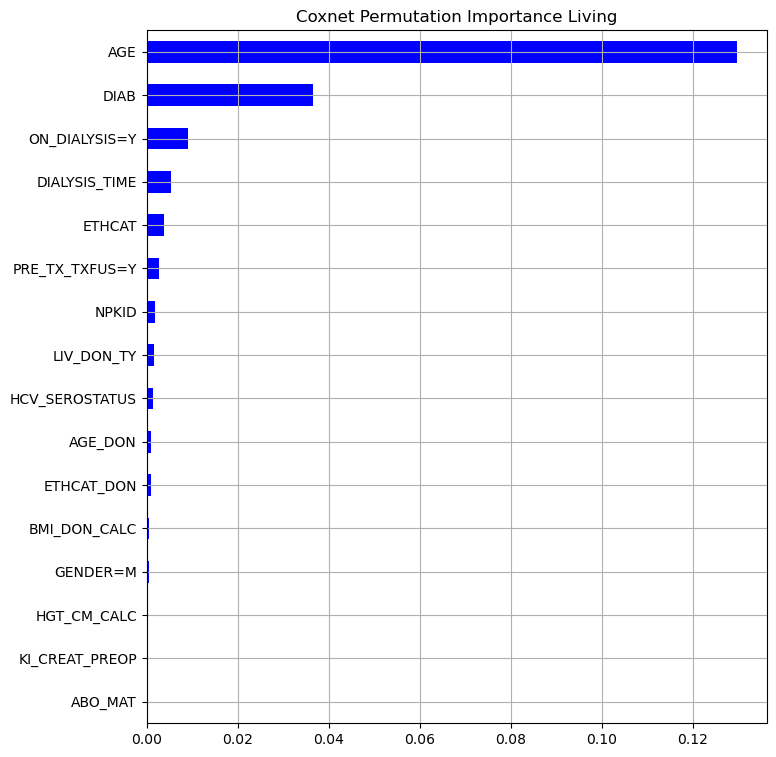

In [90]:
import matplotlib.pyplot as plt
plt_importances = importances_df.sort_values(by='Importance', ascending=True)
plt_importances['Importance']=plt_importances['Importance'].astype(float)
path = "../Thesis/Images/Results/"


diab = ["DIAB=3.0", "DIAB=5.0", "DIAB=2.0", "DIAB=4.0", "DIAB=998.0"]
eth = ["ETHCAT=2", "ETHCAT=5", "ETHCAT=4", "ETHCAT=9", "ETHCAT=6", "ETHCAT=7"]
eth_don = ["ETHCAT_DON=2.0", "ETHCAT_DON=5.0", "ETHCAT_DON=4.0", "ETHCAT_DON=9.0", "ETHCAT_DON=6.0", "ETHCAT_DON=7.0"]
liv_don_ty = ["LIV_DON_TY=6.0", "LIV_DON_TY=9.0", "LIV_DON_TY=11.0", "LIV_DON_TY=8.0", "LIV_DON_TY=5.0", "LIV_DON_TY=2.0", "LIV_DON_TY=12.0", "LIV_DON_TY=3.0", "LIV_DON_TY=10.0", "LIV_DON_TY=7.0", "LIV_DON_TY=999.0", "LIV_DON_TY=4.0"]
abo = ["ABO_MAT=2.0", "ABO_MAT=3.0"]
hcv = ["HCV_SEROSTATUS=ND", "HCV_SEROSTATUS=P"]
hbv = ["HBV_CORE=P", "HBV_CORE=ND"]


plt_importances.loc["DIAB", 'Importance'] = plt_importances.loc[diab, 'Importance'].sum()
plt_importances.loc["ETHCAT", 'Importance'] = plt_importances.loc[eth, 'Importance'].sum()
plt_importances.loc["ETHCAT_DON", 'Importance'] = plt_importances.loc[eth_don, 'Importance'].sum()
plt_importances.loc["LIV_DON_TY", 'Importance'] = plt_importances.loc[liv_don_ty, 'Importance'].sum()
plt_importances.loc["ABO_MAT", 'Importance'] = plt_importances.loc[abo, 'Importance'].sum()
plt_importances.loc["HCV_SEROSTATUS", 'Importance'] = plt_importances.loc[hcv, 'Importance'].sum()

plt_importances.drop(diab, inplace=True)
plt_importances.drop(eth, inplace=True)
plt_importances.drop(eth_don, inplace=True)
plt_importances.drop(liv_don_ty, inplace=True)
plt_importances.drop(abo, inplace=True)
plt_importances.drop(hcv, inplace=True)
plt_importances.drop(hbv, inplace=True)

plt_importances.sort_values(by='Importance', ascending=True, inplace=True)
plt_importances.plot.barh(color='blue', legend=False, title='Coxnet Permutation Importance Living', grid=True, figsize=(8, 9))

plt.savefig(path + "Coxnet_FI_living.pdf", bbox_inches="tight")
